## Análisis exploratorio de datos

### Descargo las librerías

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind

### Importo los datasets

In [2]:
companies = pd.read_csv('/datasets/project_sql_result_01.csv')
neighborhoods = pd.read_csv('/datasets/project_sql_result_04.csv')
trips = pd.read_csv('/datasets/project_sql_result_07.csv')

### Estudio lo que contienen extrrayendo solo las primeras filas para estudiar los datos

In [3]:
print(companies.head())

                      company_name  trips_amount
0                        Flash Cab         19558
1        Taxi Affiliation Services         11422
2                Medallion Leasing         10367
3                       Yellow Cab          9888
4  Taxi Affiliation Service Yellow          9299


In [4]:
print(neighborhoods.head())

  dropoff_location_name  average_trips
0                  Loop   10727.466667
1           River North    9523.666667
2         Streeterville    6664.666667
3             West Loop    5163.666667
4                O'Hare    2546.900000


In [5]:
print(trips.head())

              start_ts weather_conditions  duration_seconds
0  2017-11-25 16:00:00               Good            2410.0
1  2017-11-25 14:00:00               Good            1920.0
2  2017-11-25 12:00:00               Good            1543.0
3  2017-11-04 10:00:00               Good            2512.0
4  2017-11-11 07:00:00               Good            1440.0


### Me aseguro de que los datos estén correctos

In [6]:
#Como tengo una columna de fechas en Trips, entonces lo convierto a datetime

trips['start_ts'] = pd.to_datetime(trips['start_ts'])

Confirmo que todos los datos numéricos estén en el formato correcto

In [7]:
companies['trips_amount'] = pd.to_numeric(companies['trips_amount'], errors='coerce')

In [8]:
neighborhoods['average_trips'] = pd.to_numeric(neighborhoods['average_trips'], errors='coerce')

In [9]:
trips['duration_seconds'] = pd.to_numeric(trips['duration_seconds'], errors='coerce')

Ahora reviso si hay valores nulos

In [10]:
print(companies.isnull().sum())

company_name    0
trips_amount    0
dtype: int64


In [11]:
print(neighborhoods.isnull().sum())

dropoff_location_name    0
average_trips            0
dtype: int64


In [12]:
print(trips.isnull().sum())

start_ts              0
weather_conditions    0
duration_seconds      0
dtype: int64


Como no hay valores nulos, puedo continuar...

### Identificar los 10 principales barrios en términos de finalización del recorrido

In [13]:
top_10_neighborhoods = neighborhoods.sort_values(by='average_trips', ascending=False).head(10)
print(top_10_neighborhoods)

  dropoff_location_name  average_trips
0                  Loop   10727.466667
1           River North    9523.666667
2         Streeterville    6664.666667
3             West Loop    5163.666667
4                O'Hare    2546.900000
5             Lake View    2420.966667
6            Grant Park    2068.533333
7         Museum Campus    1510.000000
8            Gold Coast    1364.233333
9    Sheffield & DePaul    1259.766667


### Hacer gráficos: empresas de taxis y número de viajes, los 10 barrios principales por número de finalizaciones

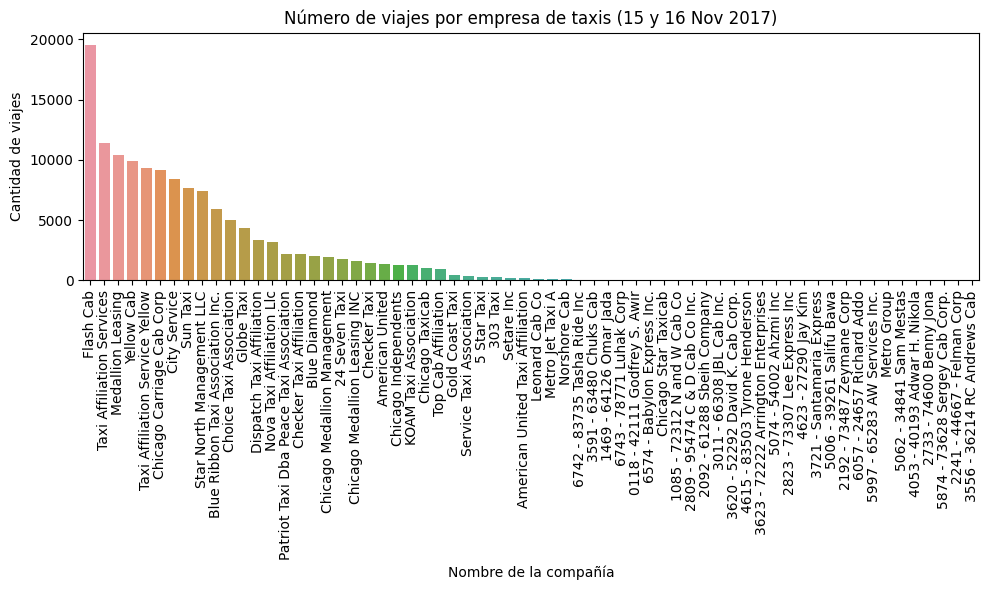

In [14]:
plt.figure(figsize=(10,6))
sns.barplot(data=companies, x='company_name', y='trips_amount')
plt.title('Número de viajes por empresa de taxis (15 y 16 Nov 2017)')
plt.xlabel('Nombre de la compañía')
plt.ylabel('Cantidad de viajes')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

Basandonos en el resultado del grfico, podemos darnos cuenta que la empresa con más viajes tomados por usuarios es la de Flash Cab. Se puede decir que casi que duplica a las otras empresas de servicios de carros, llevándonos a decucir que puede ser la más popular. Tocaría entrar a ver más en detalle si se debe a temas de precios asequibles o al servicio que prestan que puede sobresalir por encima de las otras.

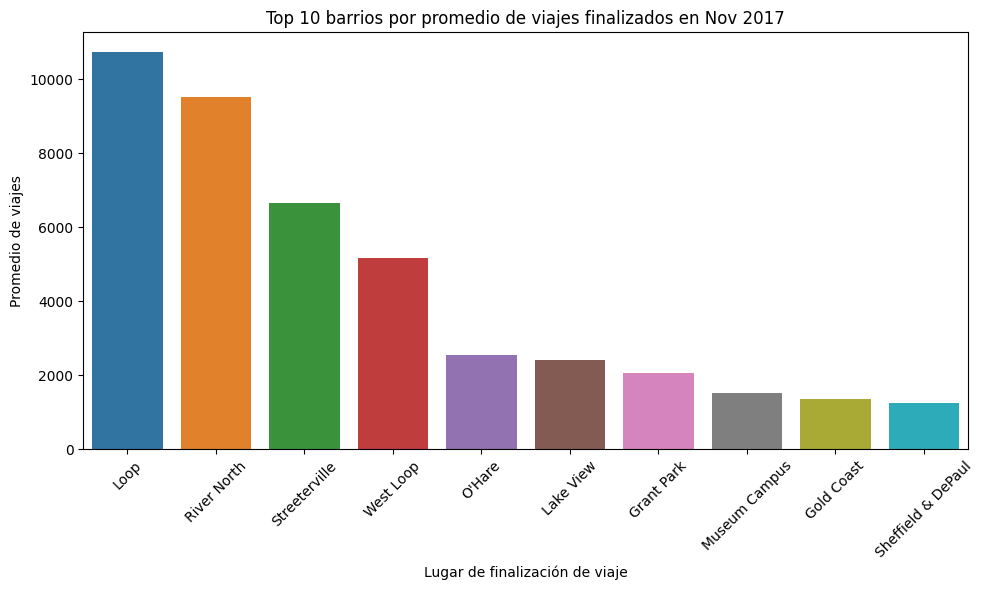

In [15]:
plt.figure(figsize=(10,6))
sns.barplot(data=top_10_neighborhoods, x='dropoff_location_name', y='average_trips')
plt.title('Top 10 barrios por promedio de viajes finalizados en Nov 2017')
plt.xlabel('Lugar de finalización de viaje')
plt.ylabel('Promedio de viajes')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Revisando el gráfico, podemos darnos cuenta que los destinos más populares hacia los que viajan los pasajeros son: Loop, River North, Streetville y West Loop. Es posible que sean los lugares donde viven la mayoría de usuarios que toman este servicio.

### Prueba de hipótesis (Python)

Queremos probar que:

Hipótesis nula (H0): La duración promedio de los viajes desde el Loop hasta O’Hare no cambia los sábados lluviosos comparados con otros sábados.

Hipótesis alternativa (H1): La duración promedio sí cambia en los sábados lluviosos.

Como queremos comparar la duración de viajes, los separamos en dos grupos:

Sábados con condiciones 'Bad' (lluvia o tormenta)

Sábados con condiciones 'Good'

In [16]:
#Filtramos por los días sábados, que es lo que nos interesa.
trips['day_of_week'] = trips['start_ts'].dt.dayofweek

In [17]:
# Decimos que el sábado es el día 5.
saturdays = trips[trips['day_of_week'] == 5]

In [18]:
group_bad = saturdays[saturdays['weather_conditions'] == 'Bad']['duration_seconds']
group_good = saturdays[saturdays['weather_conditions'] == 'Good']['duration_seconds']

Usaremos un test t de Student para muestras independientes.

In [19]:
t_stat, p_value = ttest_ind(group_bad, group_good, equal_var=False)

print(f"t-statistic: {t_stat}")
print(f"p-value: {p_value}")

if p_value < 0.05: #Usamos como valor de significancia el 0.05
    print("Se rechaza la hipótesis nula")
else:
    print("No se rechaza la hipótesis nula")

t-statistic: 7.186034288068629
p-value: 6.738994326108734e-12
Se rechaza la hipótesis nula


Podemos decir que, al rechazar la hipótesis nula, la duración promedio del viaje entre Loop hasta el Aeropuesto O'Hare cambia los días sábados cuando llueve. Así que el factor climárico puede ser crucial para los usuarios a la hora de tomar un servicio.

Como sabemos que en día de lluvia los viajes duran mucho más, puede ser una oportunidad para tener tarífas dinámicas que ayuden a amortiguar los costos por gasolina de los conductores, elevando los precios.

Del mismo modo, esto sería un insentivo para la compañía para que más conductores salgan a trabajar, así pueden ganar significativamente más, sobretodo en las circuntancias en las que la gente necesita desplazarse a un aeropuerto, porque van cargados de maletas.